In [1]:
import evals
from tensorflow import keras
import tensorflow as tf
import IJB_evals
import matplotlib.pyplot as plt
import keras_cv_attention_models
import GhostFaceNets, GhostFaceNets_with_Bias
from models import NormDense, NormDenseVPL

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# GhostFaceNet Model
custom_objects = {
    "NormDense": NormDense,
    "NormDenseVPL": NormDenseVPL
}

model_path = 'base_model_no_changes_5k_images/ghostnetv1_w1.3_s2_basic_model_latest.h5'
model = keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [4]:
import numpy as np
from keras.models import load_model, Model, Sequential
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, UpSampling2D, Conv2D
from keras.utils import load_img, img_to_array
from keras.optimizers import Adam
import os
import matplotlib.pyplot as plt


def generate_embedding(img_path):
    img = load_img(img_path, target_size=(112, 112))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    embedding = model.predict(img_array)
    return embedding

1/1 [==============================] - 0s 91ms/step
EER: 0.07503565079185591
Accuracy: 0.9249637818480644


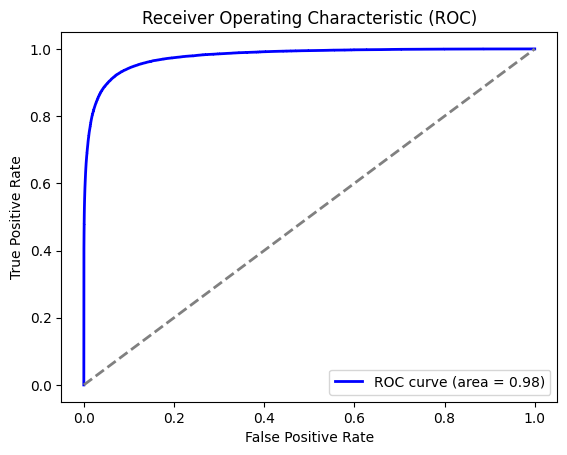

In [5]:
import os
import numpy as np
from sklearn.metrics import roc_curve, accuracy_score, auc
import matplotlib.pyplot as plt

def cosine_distance(emb1, emb2):
    emb1 = emb1.flatten()
    emb2 = emb2.flatten()
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

image_folder = 'datasets/faces_emore_112x112_folders'
true_labels = []
pred_distances = []

for i in range(8000, 8020):
    subfolder_path = os.path.join(image_folder, str(i))
    if os.path.isdir(subfolder_path):
        embeddings = []
        img_names = []
        for img_name in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_name)
            embedding = generate_embedding(img_path)
            embeddings.append(embedding)
            img_names.append(img_name)
        
        for j in range(len(embeddings)):
            for k in range(j + 1, len(embeddings)):
                distance = cosine_distance(embeddings[j], embeddings[k])
                pred_distances.append(distance)
                true_labels.append(1)

for i in range(8000, 8019):
    subfolder_path1 = os.path.join(image_folder, str(i))
    if os.path.isdir(subfolder_path1):
        embeddings1 = []
        for img_name in os.listdir(subfolder_path1):
            img_path1 = os.path.join(subfolder_path1, img_name)
            embedding1 = generate_embedding(img_path1)
            embeddings1.append(embedding1)
        
        for j in range(i + 1, 8020):
            subfolder_path2 = os.path.join(image_folder, str(j))
            if os.path.isdir(subfolder_path2):
                embeddings2 = []
                for img_name in os.listdir(subfolder_path2):
                    img_path2 = os.path.join(subfolder_path2, img_name)
                    embedding2 = generate_embedding(img_path2)
                    embeddings2.append(embedding2)
                
                for emb1 in embeddings1:
                    for emb2 in embeddings2:
                        distance = cosine_distance(emb1, emb2)
                        pred_distances.append(distance)
                        true_labels.append(0)

if not true_labels:
    raise ValueError("true_labels is empty. Ensure the image folders and their contents are correct.")
if not pred_distances:
    raise ValueError("pred_distances is empty. Ensure embeddings are generated correctly.")

fpr, tpr, thresholds = roc_curve(true_labels, pred_distances, pos_label=1)
eer_threshold = thresholds[np.nanargmin(np.abs(fpr - (1 - tpr)))]
eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
roc_auc = auc(fpr, tpr)

y_pred = [1 if d >= eer_threshold else 0 for d in pred_distances]
accuracy = accuracy_score(true_labels, y_pred)

print(f'EER: {eer}')
print(f'Accuracy: {accuracy}')

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
